<a href="https://colab.research.google.com/github/PDDA-OPDU/MICP-Analytics/blob/main/Gaussian_KGS_Data_CDF_PDF/CDF_PDF_Distributions_KGS_data.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:


    !wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Gaussian_KGS_Data_CDF_PDF/CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


# Load Python Libraries:

In [3]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

import seaborn as sns

from sklearn.metrics import r2_score


# Load Data

## The following cells will load the HPMI data from Kansas Geologic Survey data. 

## 1) Load  row of HPMI data starting at row A12:A130 for Pc and xxx12 to xxx130 for Sw

In [4]:
# Function to convert a number to an Excel-style column letter (supports beyond Z)
def get_column_letter(n):
    result = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        result = chr(65 + remainder) + result
    return result

# Specify the file path and sheet number
file_path = 'CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
sheet_number = 0  # Second sheet, as pandas uses zero-indexing

# Read the Pc values (same for all samples)
pc_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A", skiprows=11, nrows=119)

# Initialize a dictionary to store data for each sample
data_dict = {}

# Loop through each sample (from column B onward)
# Adjust the range according to the number of samples we need to process
for sample_num in range(1, 36):  # Example for 51 samples, adjust as necessary
    column_letter = get_column_letter(sample_num + 1)  # +1 because 'B' is column 2
    #print(f"Processing sample {sample_num} (Column {column_letter})")

    # Read Sw values for the current sample
    sw_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=11, nrows=119)
    
    # Read Porosity for the current sample (assumed to be in row 8)
    porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=7, nrows=1).iloc[0, 0]
    
    # Read Permeability for the current sample (assumed to be in row 9)
    permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=8, nrows=1).iloc[0, 0]

    # Read Num of Pore systems for the current sample (assumed to be in row 10)
    Num_pore_sys = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=9, nrows=1).iloc[0, 0]
    #print(Num_pore_sys)

    # Store the data in the dictionary
    data_dict[f'Sample_{sample_num}'] = {
        'Pc': pc_values.values.flatten(),
        'Sw': sw_values.values.flatten(),
        'Porosity (%)': porosity,
        'Permeability': permeability,
        'Num_pore_sys': Num_pore_sys,
    }

# Now, data_dict contains the data for all samples, structured for easy access
#print(data_dict)

# Batch 1, 2, or 3 from the spreadsheet
Pc_batch = 1


# 2) Run in Auto Mode:

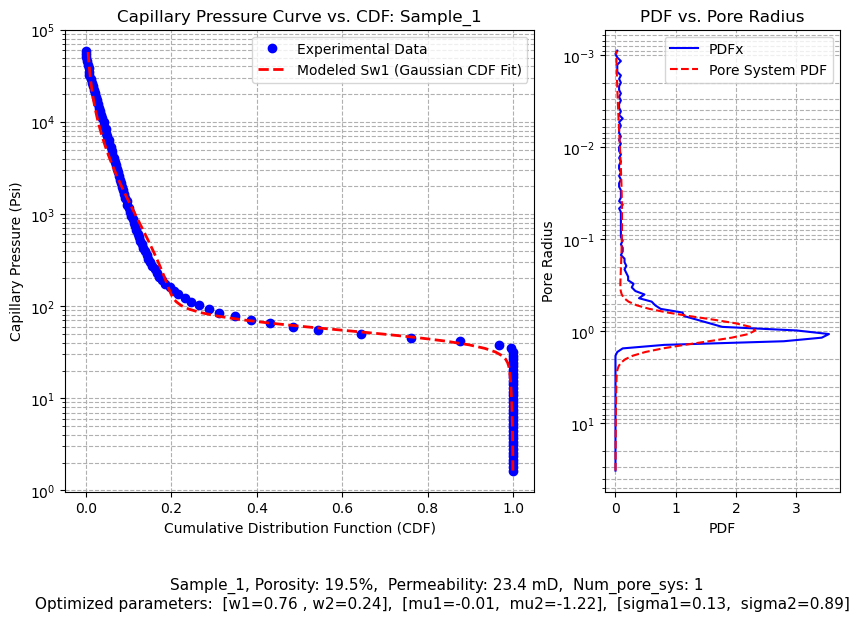

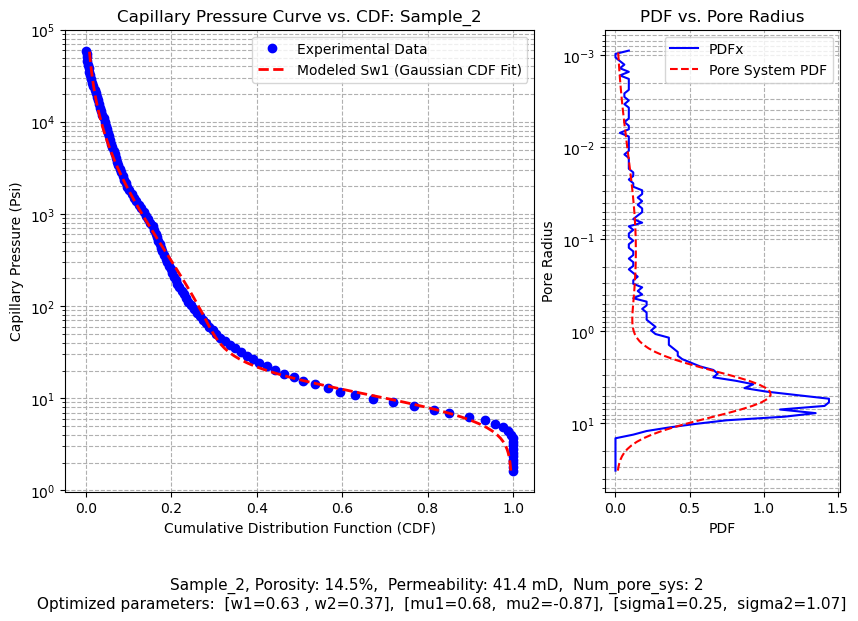

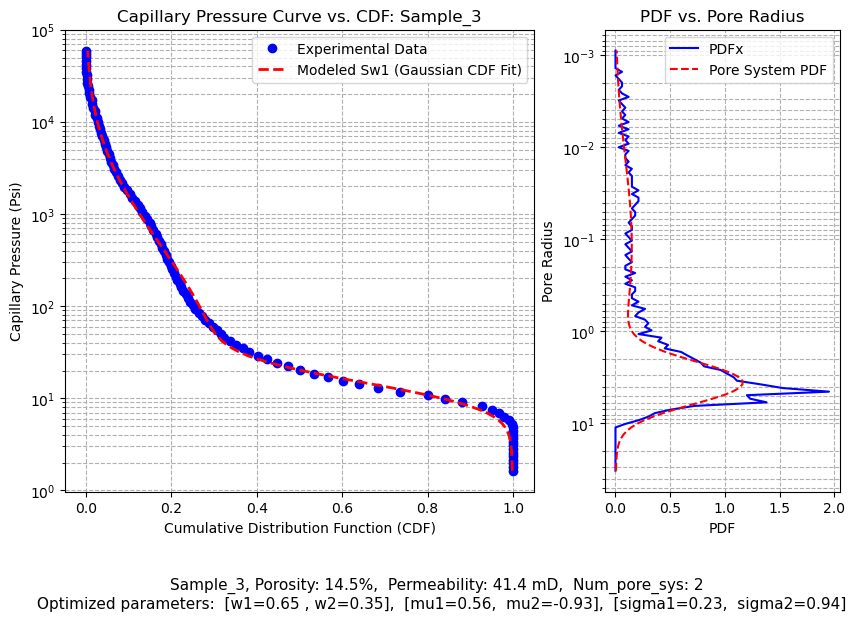

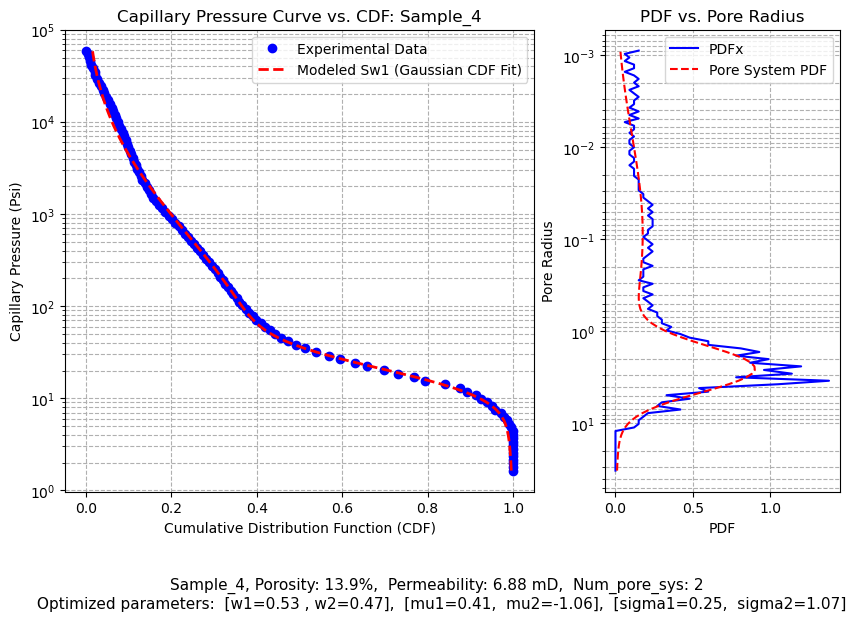

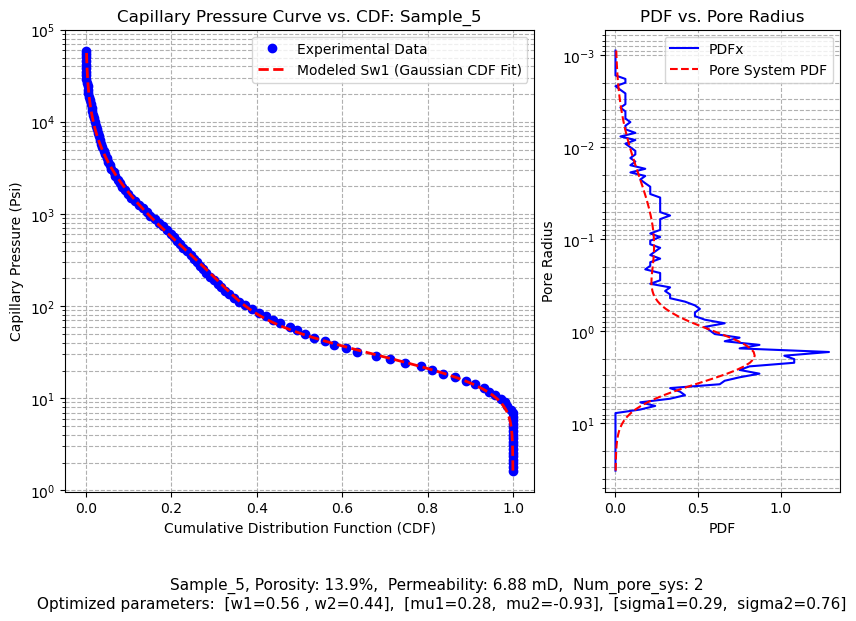

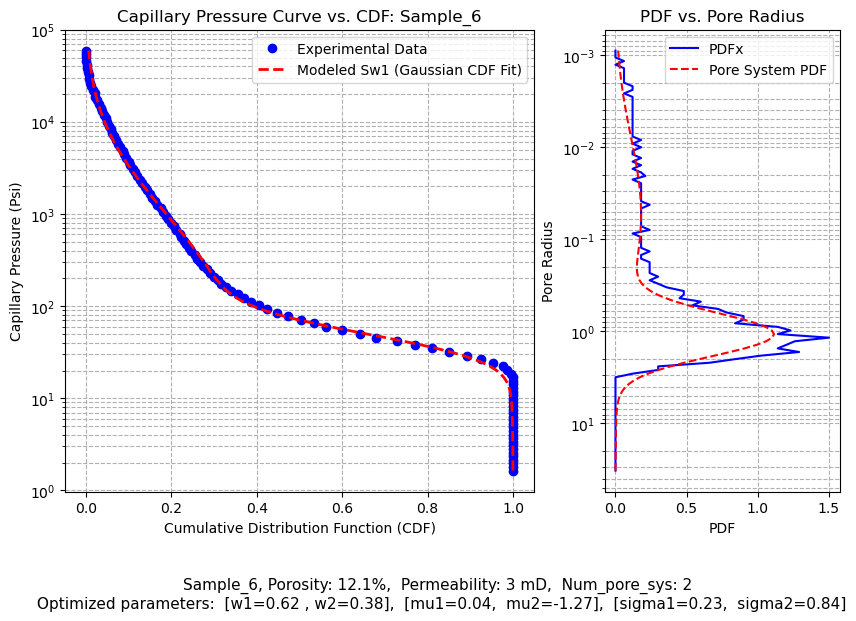

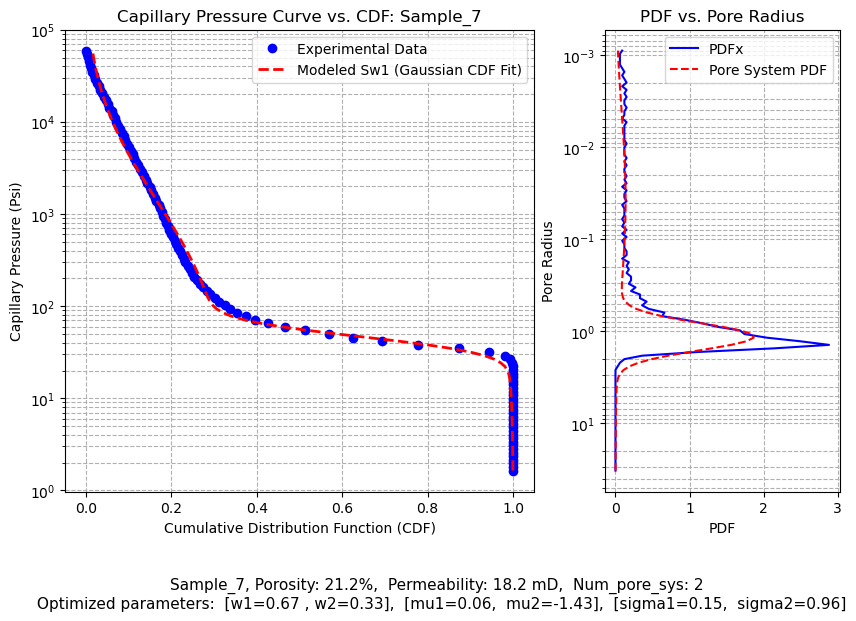

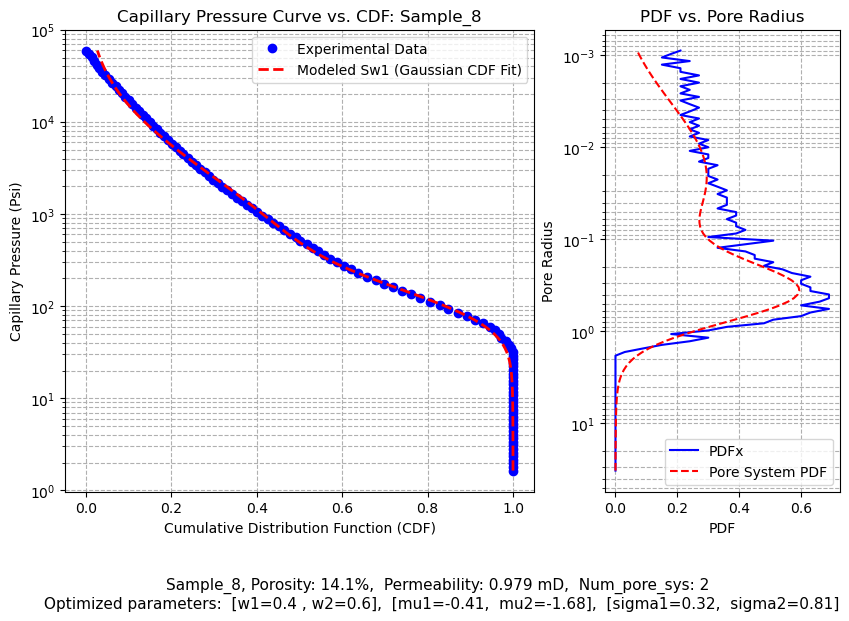

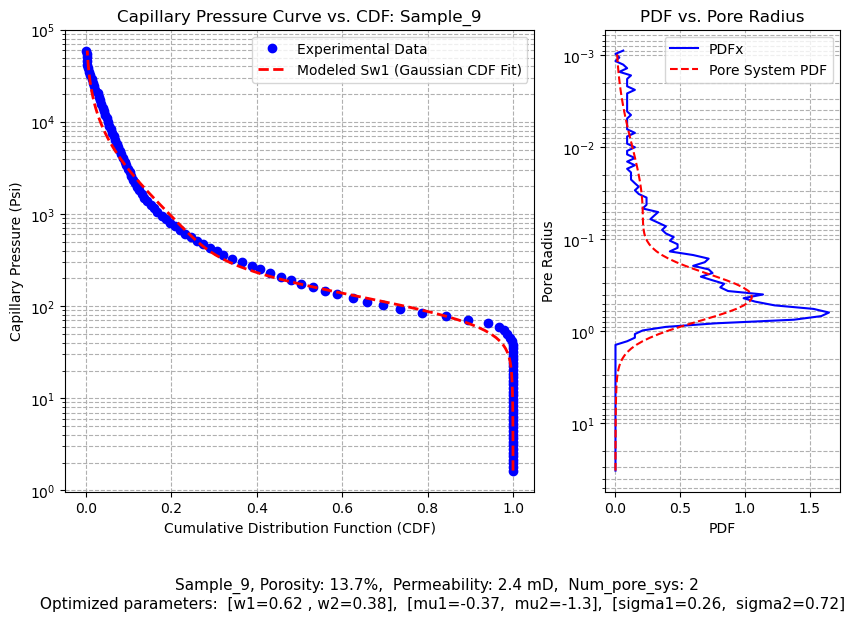

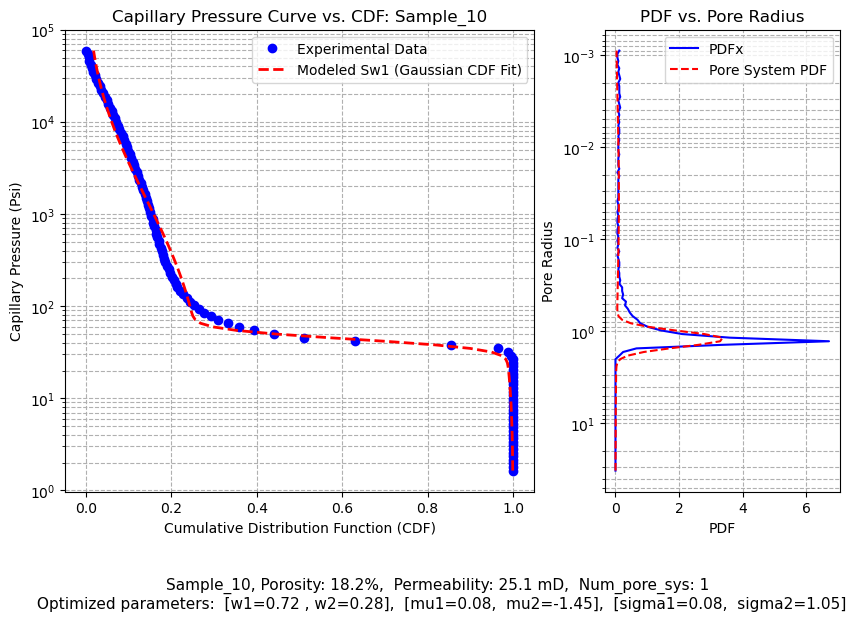

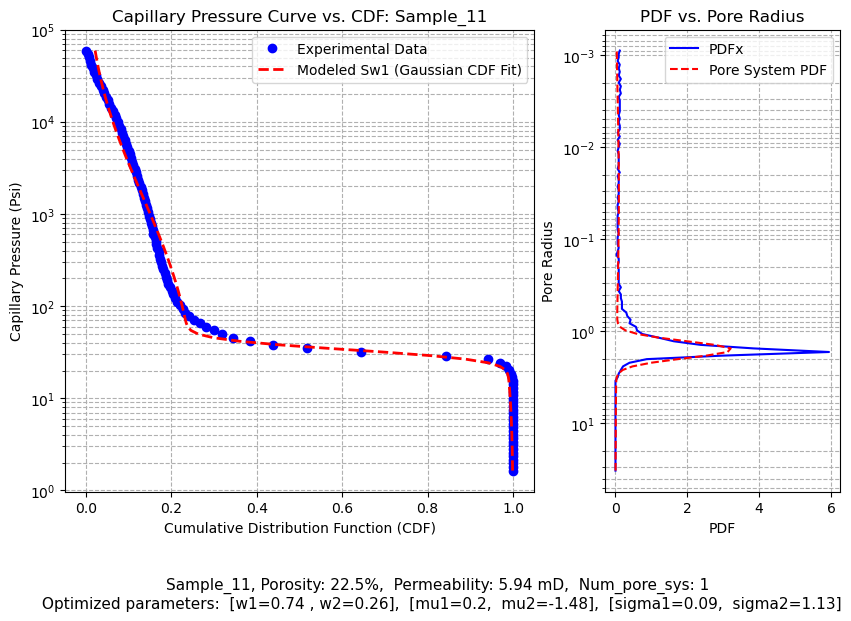

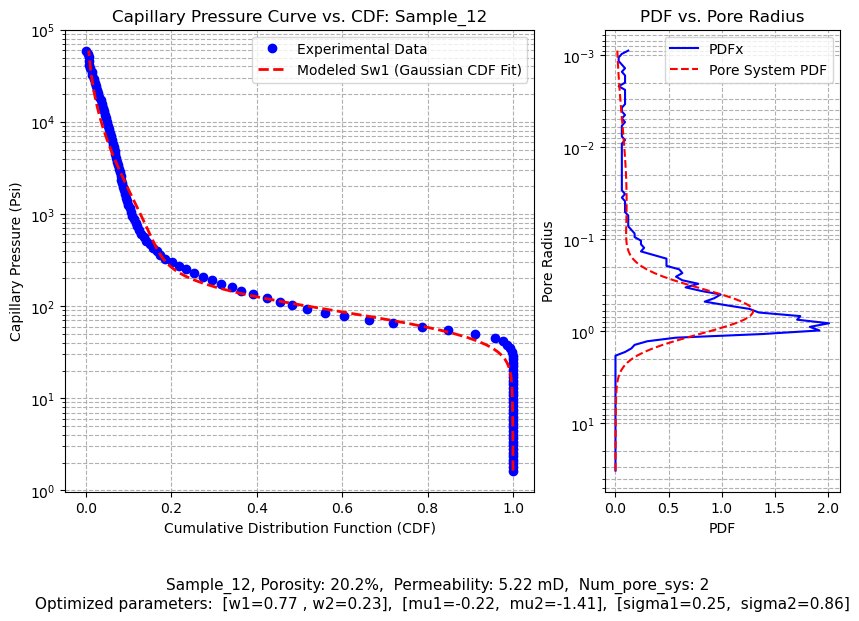

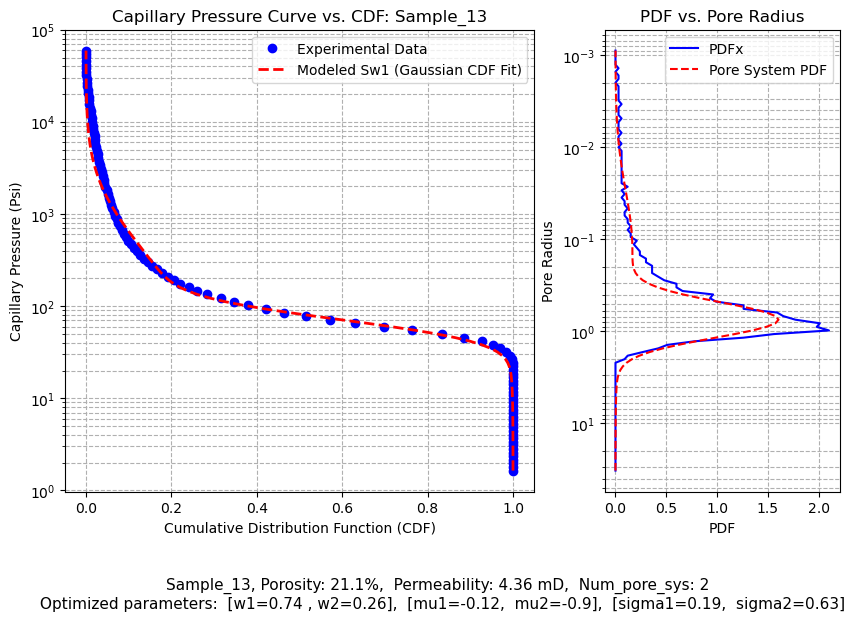

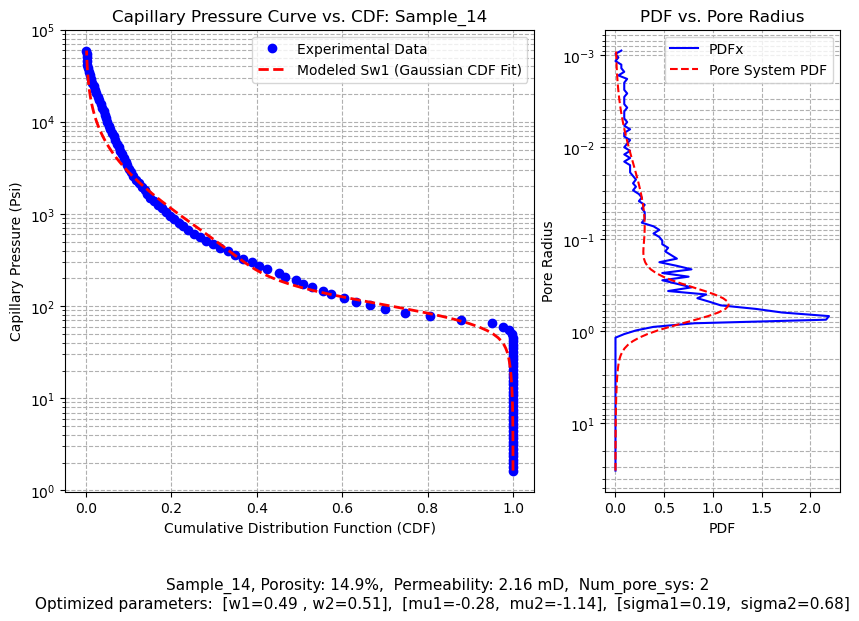

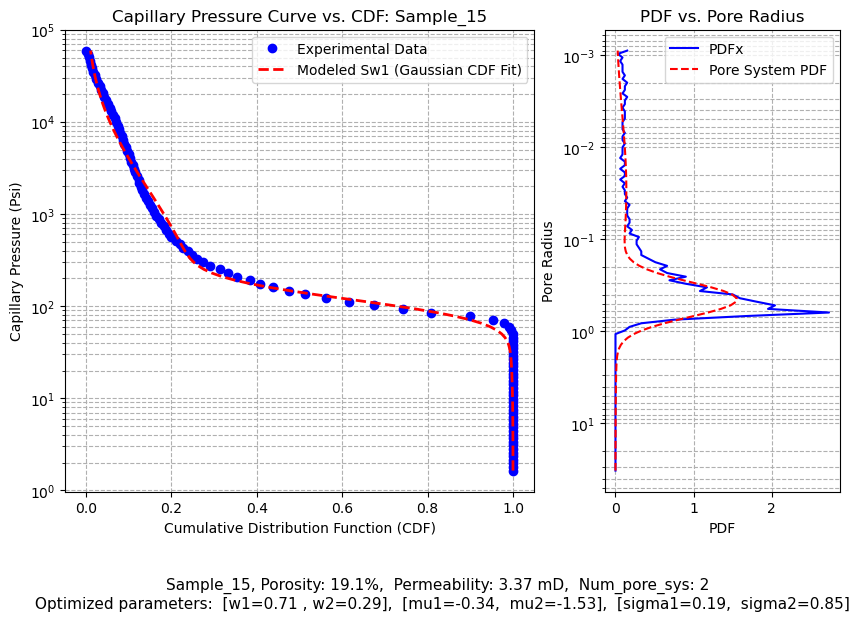

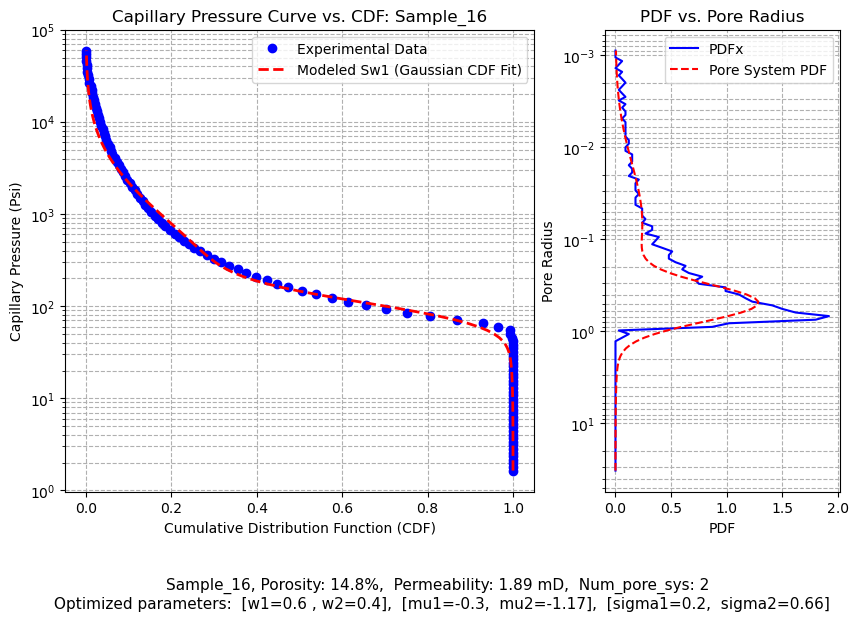

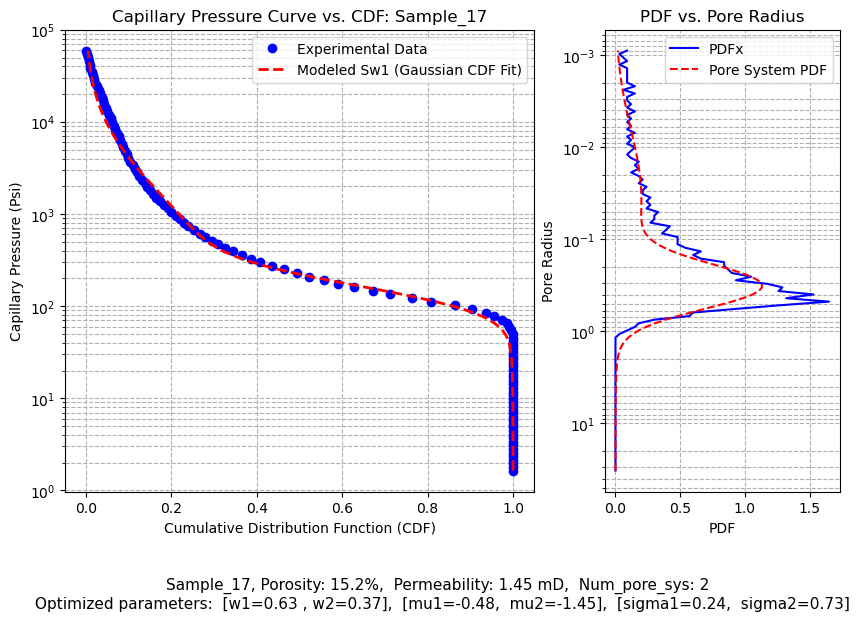

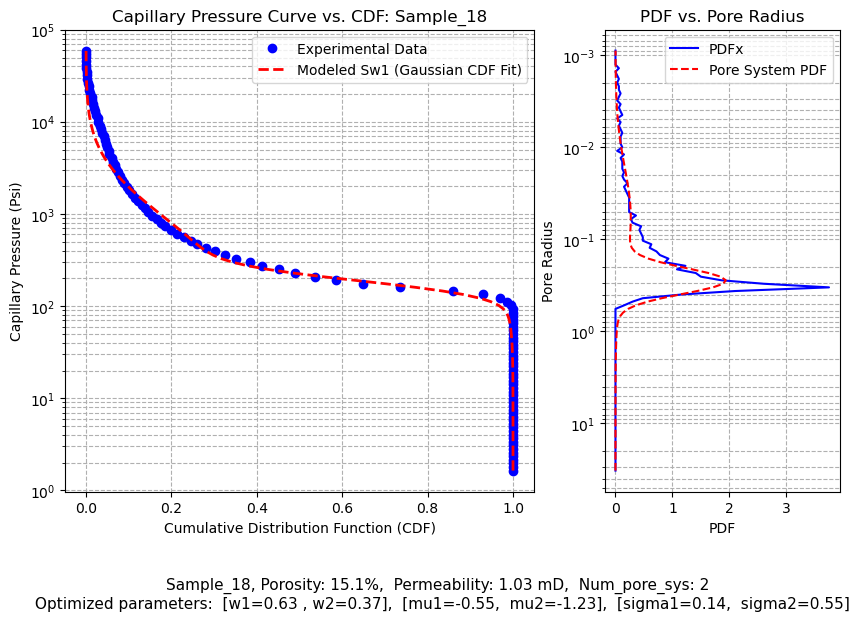

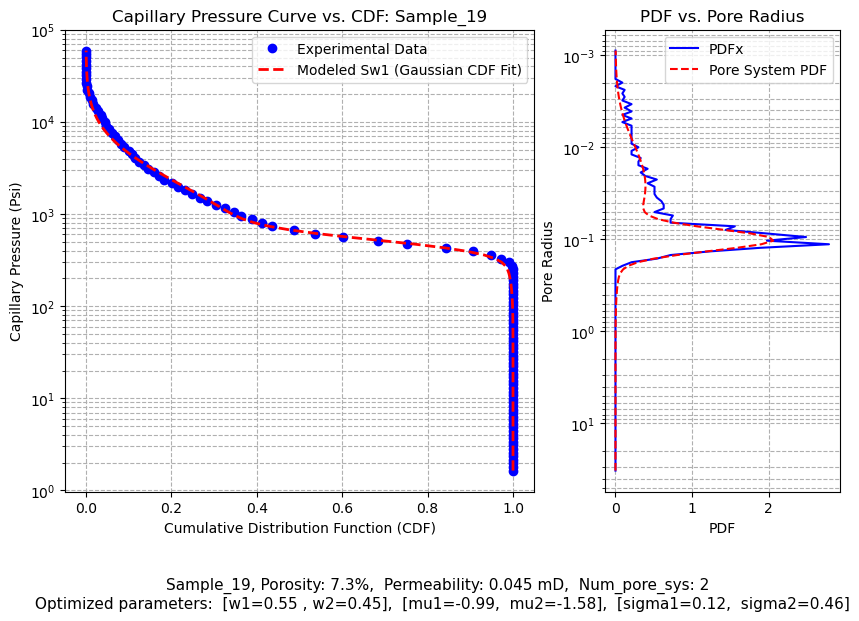

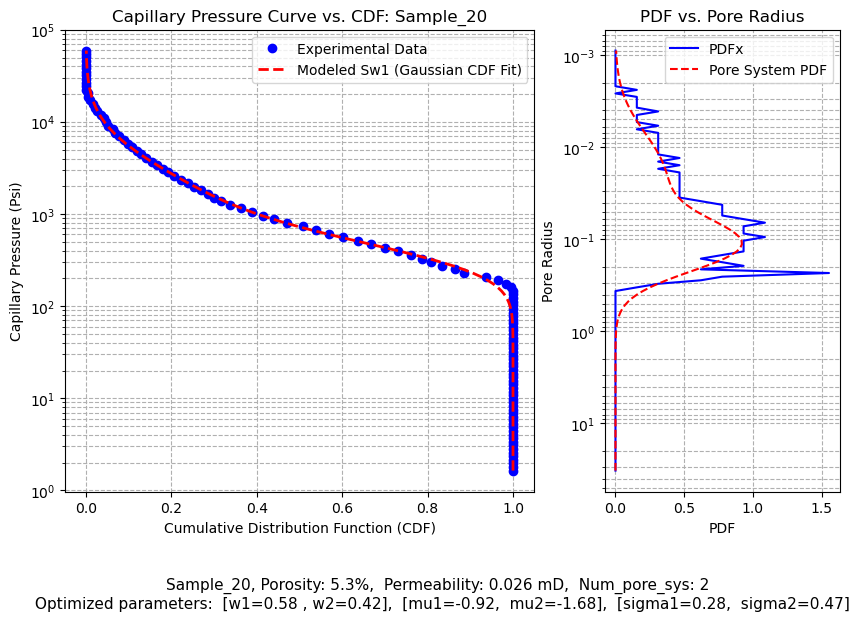

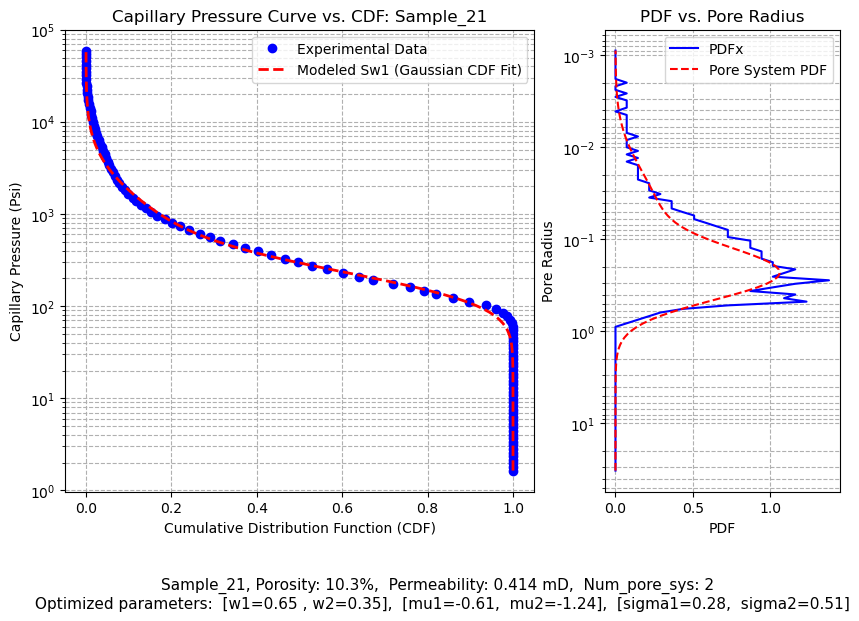

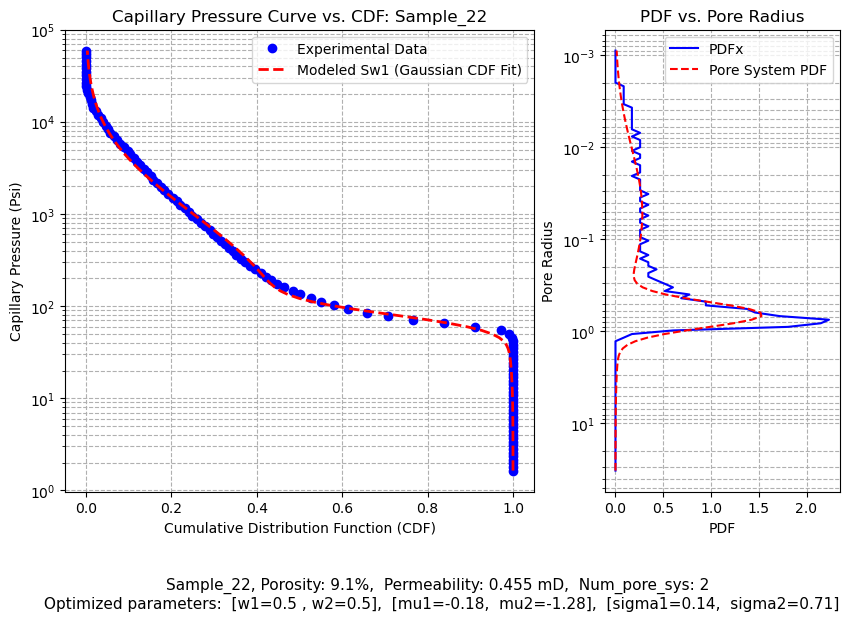

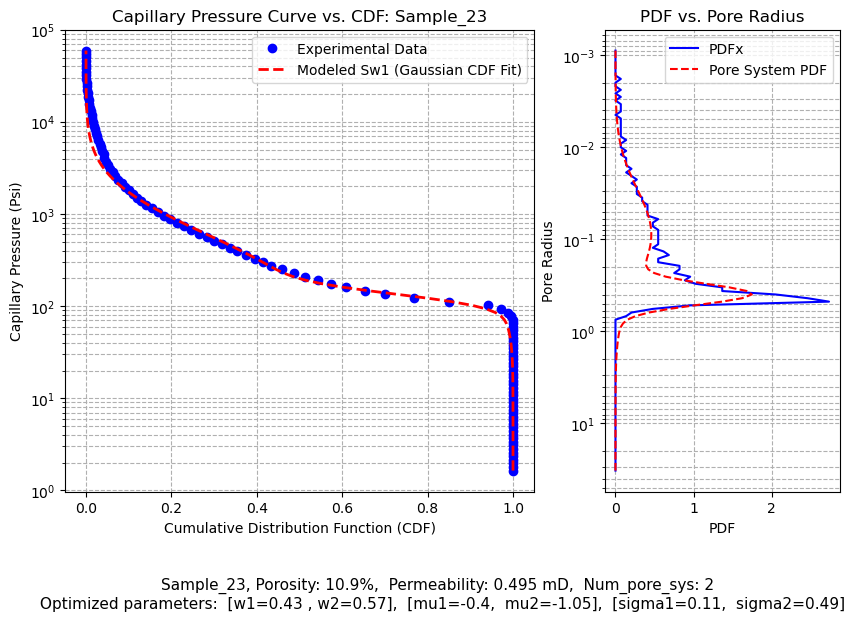

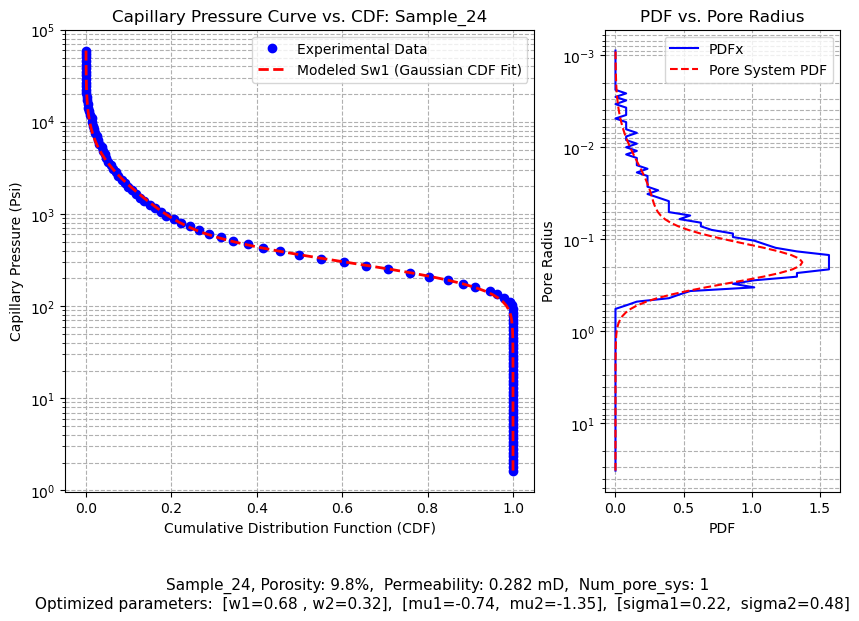

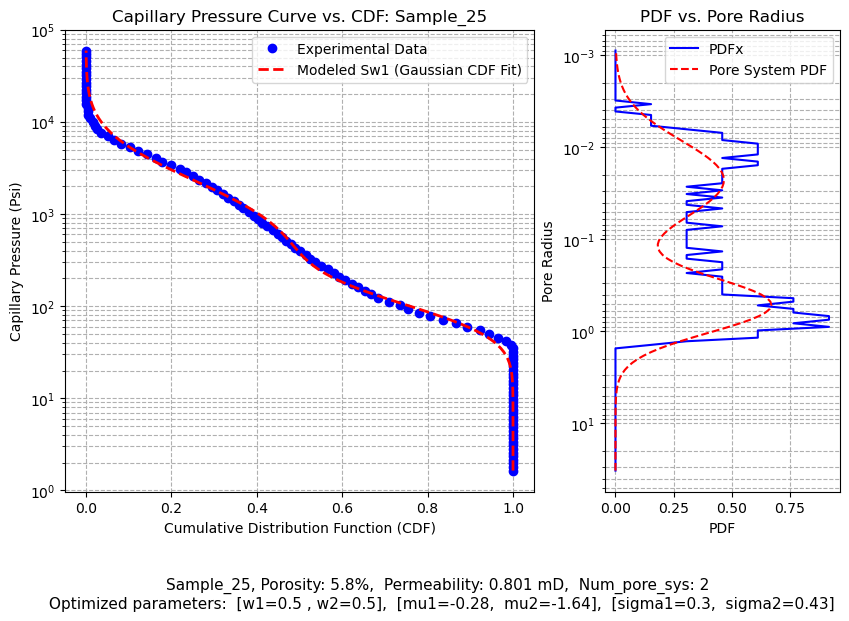

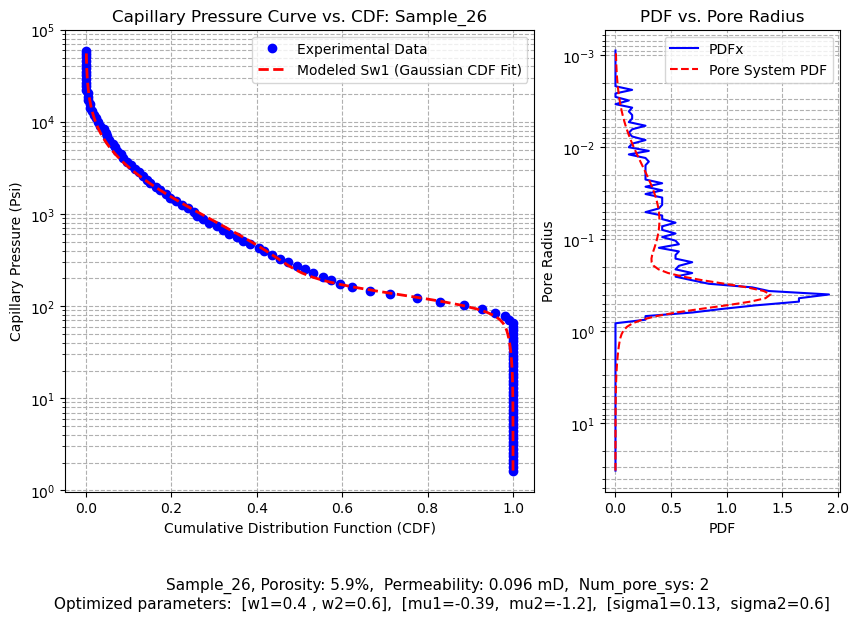

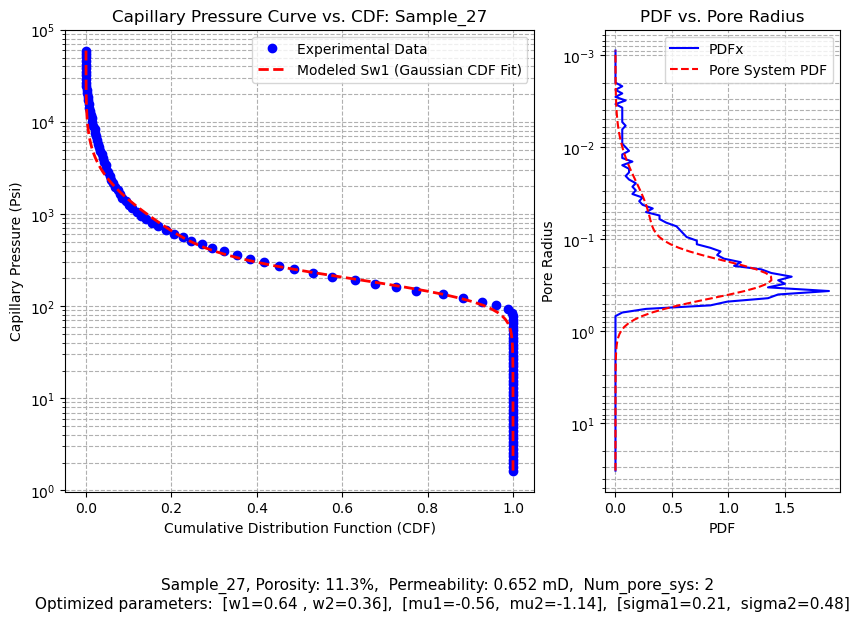

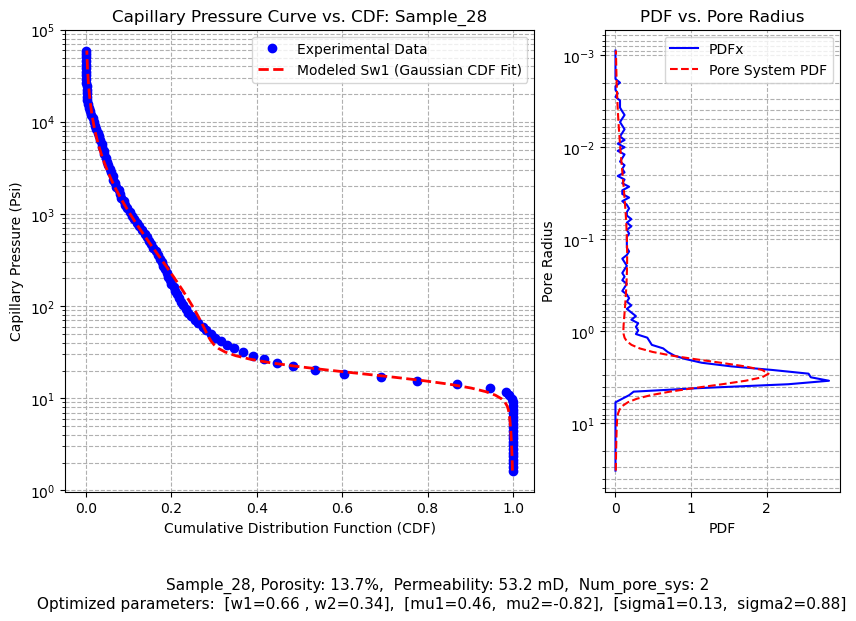

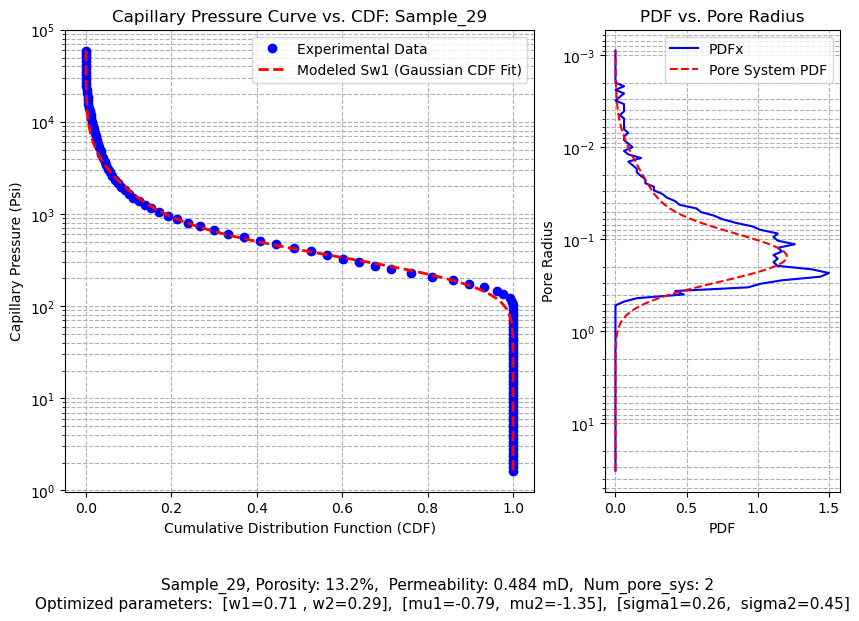

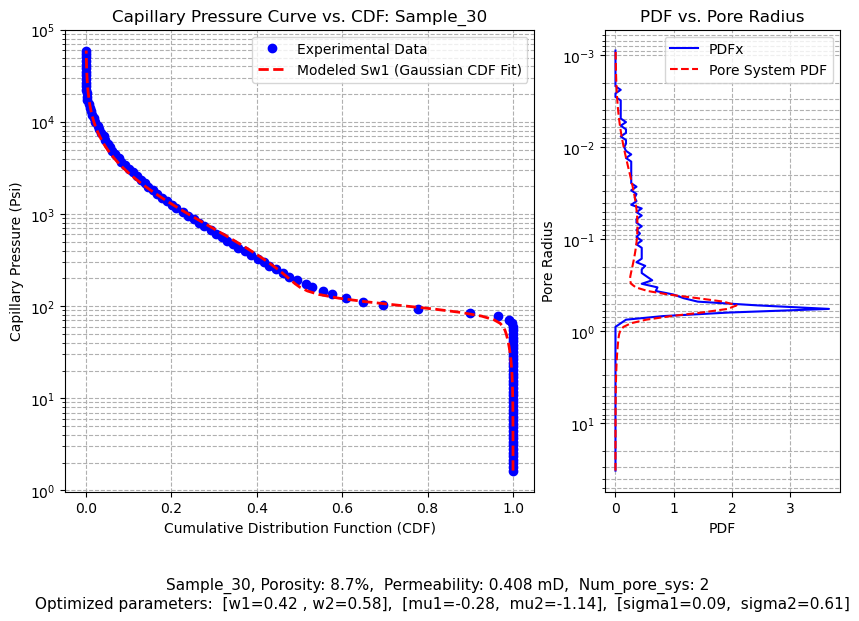

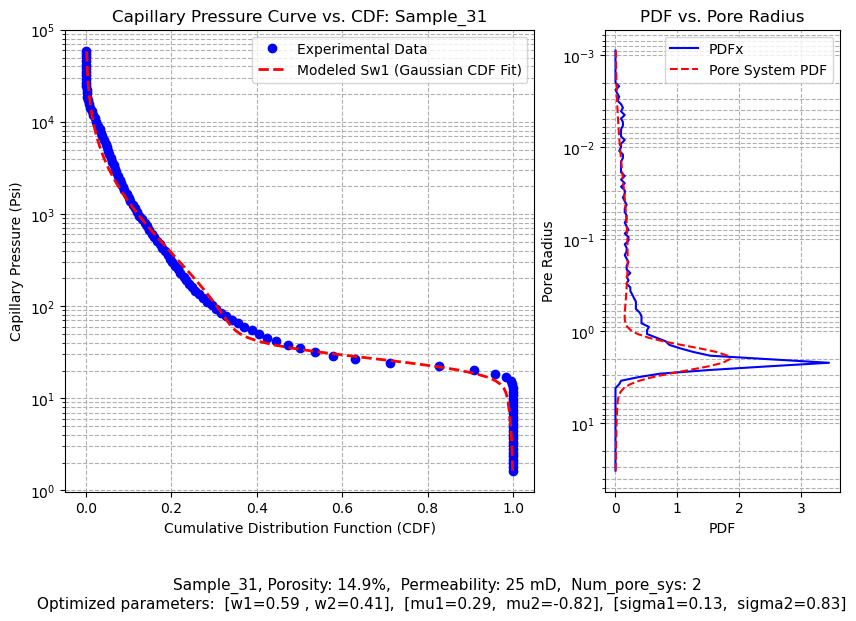

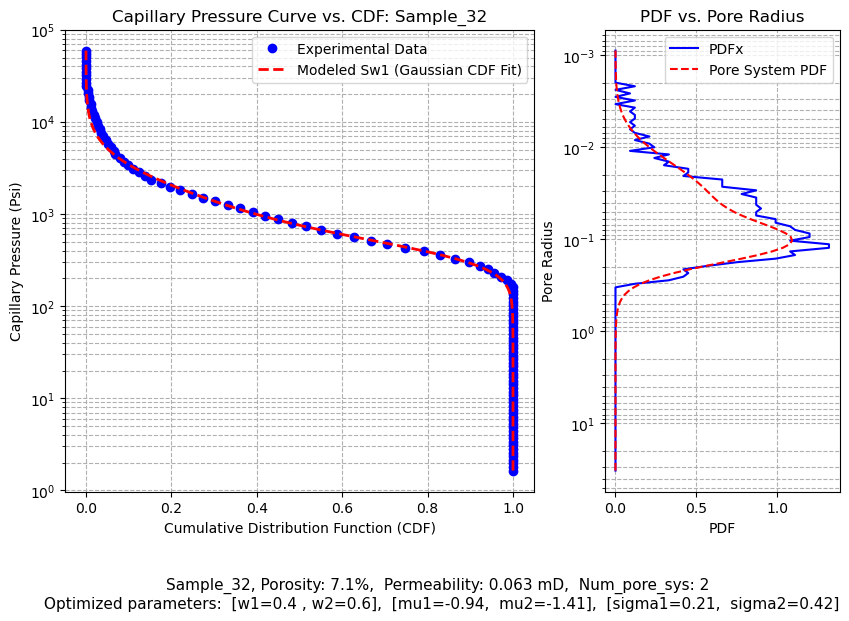

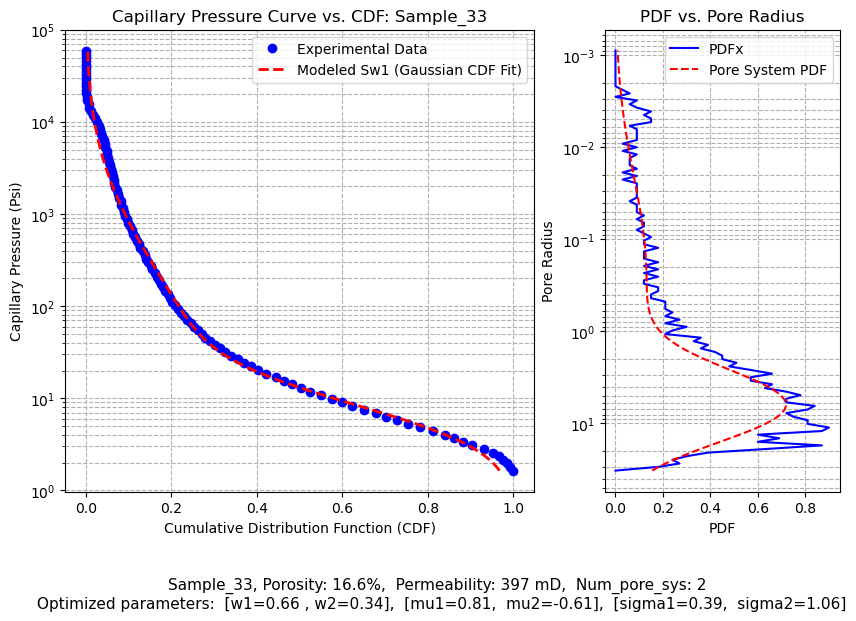

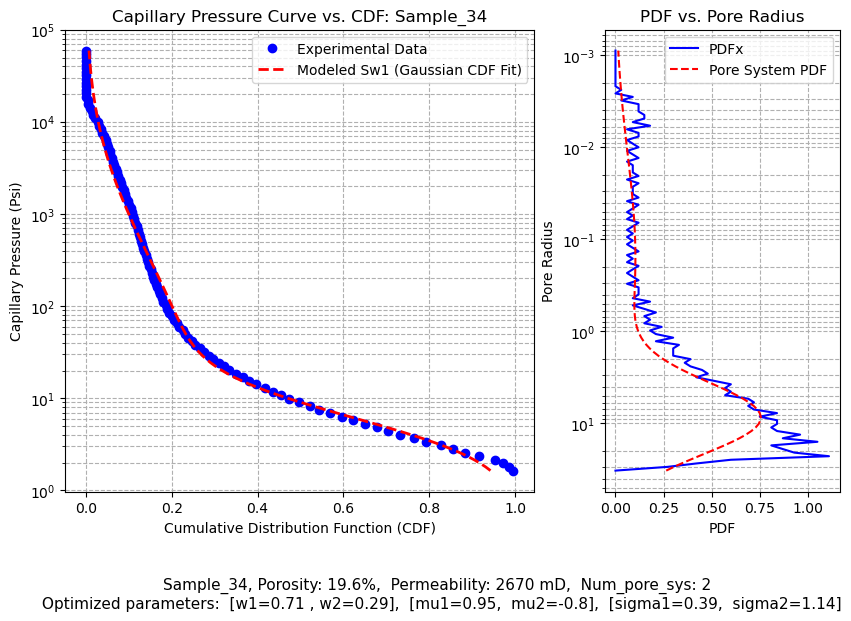

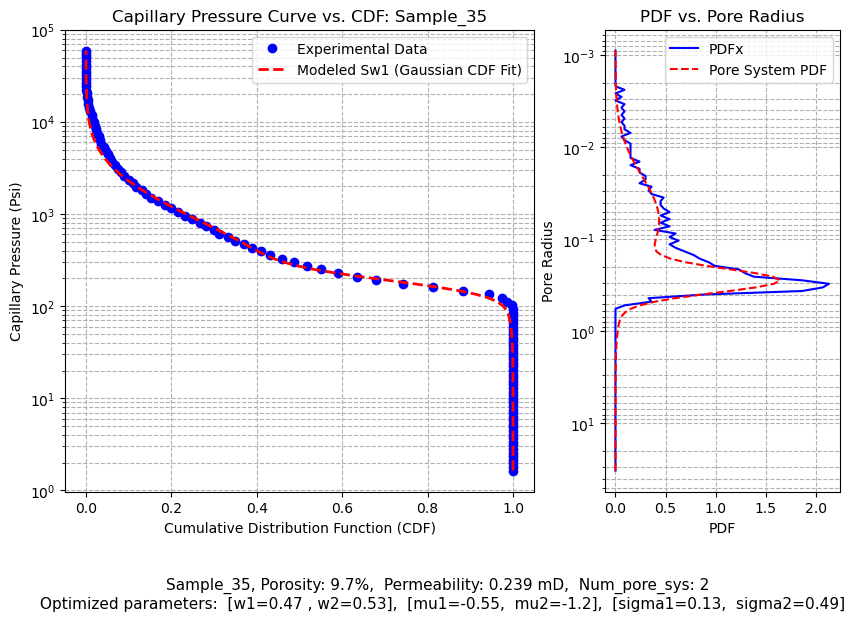

In [5]:
# Loop through all samples
for Sample in data_dict.keys():
    sample_data = data_dict[Sample]

    porosity_sample = sample_data['Porosity (%)']
    perm_sample = sample_data['Permeability']
    Num_pore_sys = sample_data['Num_pore_sys']


    Pc = sample_data['Pc']
    Sw = sample_data['Sw']/100

    
    BVocc = ((100 - Sw) / 100) * porosity_sample
    #dbvocc = np.diff(BVocc)  # diff of BVocc for distribution, but lose one element in the array
    #dbvocc = np.insert(dbvocc, 0, 0)  # Our final dbvocc after adding a zero at the start


    dSw = np.diff(-1*Sw)
    dSw = 30*np.insert(dSw,0,0)
    

    ''' Definitions '''
    
    
    def micp_to_gaussian(Pc, Sw, IFTheta, n):
        
        ############Rc = 2 * IFTheta * 0.147 / Pc
        #Rc = (((2.0 * IFTheta) / (Pc * 69035.0)) * 10000.0)      # this is microns diamter
        Rc =  (((2.0 * IFTheta) / (Pc * 69035.0)) * 10000.0) / 2  # this is microns radius  
        Rc = Rc[Rc > 0]  # Remove non-positive Rc values
    
        if len(Rc) == 0:
            raise ValueError("All Rc values are invalid.")
    
        ''' Initial guess '''
        x0 = np.array([0.2, 0.8, -2, -0.5, 0.05, 0.6])
    
        ''' Lower and upper bounds '''
        lb = np.array([0.002, 0.002, np.log10(Rc[-1]), np.log10(Rc[-1]), 0.01, 0.01])
        ub = np.array([1, 1, np.log10(Rc[0]), np.log10(Rc[0]), 5, 5])
    
        ''' Constraints '''
        Aeq = np.array([1] * n + [0] * 2 * n)
        Beq = np.array([1])
    
        ''' Objective function '''
        def gaussian_cost_function(t):
            return gaussian_cost(np.log10(Rc), Sw, t, n)
    
        ''' Minimize the objective function with constraints '''
        cons = [{'type': 'eq', 'fun': lambda t: np.dot(Aeq, t) - Beq}]
        bounds = [(low, high) for low, high in zip(lb, ub)]
    
        res = minimize(gaussian_cost_function, x0, bounds=bounds, constraints=cons, method='SLSQP')
    
        if not res.success:
            print("Optimization failed:", res.message)
            return None
    
        x = res.x
        w = x[:n]
        u = x[n:2 * n]
        sig = x[2 * n:]
    
        ''' Sort u and adjust w and sigma accordingly '''
        sorted_indices = np.argsort(u)[::-1]
        u = u[sorted_indices]
        w = w[sorted_indices]
        sig = sig[sorted_indices]
    
        ''' Calculate Sw1 and PDF '''
        Sw1 = np.zeros_like(Sw)
        pdf = np.zeros_like(Sw)
        for i in range(len(Pc)):
            if Rc[i] > 0:
                Sw1[i] = np.sum(norm.cdf(np.log10(Rc[i]), u, sig) * w)
                pdf[i] = np.sum(norm.pdf(np.log10(Rc[i]), u, sig) * w)
    
        ''' Generate Rcx and Pcx '''
        Rcx = np.logspace(-4, 4, 10000)
        Pcx = 2 * IFTheta / Rcx
        Swx = np.zeros_like(Rcx)
        Pdfx = np.zeros_like(Rcx)
        for i in range(len(Rcx)):
            if Rcx[i] > 0:
                Swx[i] = np.sum(norm.cdf(np.log10(Rcx[i]), u, sig) * w)
                Pdfx[i] = np.sum(norm.pdf(np.log10(Rcx[i]), u, sig) * w)
    
        ''' Interpolate Pc2 for Sw2 '''
        Sw2 = np.linspace(0.998, 0.02, 100)
        M = np.where(Swx < 0.99)[0]
        if len(M) > 0:
            Pc2 = np.interp(Sw2, Swx[:M[-1]], Pcx[:M[-1]])
        else:
            Pc2 = None
    
        return w, u, sig, x, Sw1, pdf, Rc, Sw2, Pc2, Rcx, Pdfx, Swx
    
    def gaussian_cost(X, c, t, n):
        w = t[:n]
        mu = t[n:2 * n]
        sigma = t[2 * n:]
    
        cm = np.zeros_like(c)
        for i in range(len(X)):
            cm[i] = np.sum(norm.cdf(X[i], mu, sigma) * w)
    
        c = np.array(c)  # Ensure c is a numpy array
        
        # Element-wise comparison
        idx = np.where(c <= 1)[0]
        e   = np.linalg.norm(cm[idx] - c[idx])
    
        return e
    
    
    def plot_micp_results2(Pc, Sw, Sw1, Rcx, Swx, Pc2=None, Sw2=None):
    
        # Create the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
        
        # Plot Capillary Pressure vs. CDF
        ax1.plot(Sw, Pc, 'bo', label='Experimental Data')
        # Plot modeled Sw1 (Gaussian Fit) vs Pc
        ax1.plot(Sw1, Pc, 'r--', linewidth = 2, label='Modeled Sw1 (Gaussian CDF Fit)')
        ax1.set_yscale('log')
        ax1.set_xlabel('Cumulative Distribution Function (CDF)')
        ax1.set_ylabel('Capillary Pressure (Psi)')
        ax1.set_title(f'Capillary Pressure Curve vs. CDF: {Sample}')
        ax1.grid(True, which="both", ls="--")
        ax1.legend()
        
        # Add the text below the plot
        text_string = (f'{Sample}, Porosity: {porosity_sample}%, '
                       f' Permeability: {perm_sample} mD,  Num_pore_sys: {Num_pore_sys} \n '
                       f'Optimized parameters:  [w1={round(w[0],2)} , w2={round(w[1],2)}],  '
                       f'[mu1={round(u[0], 2)},  mu2={round(u[1], 2)}],  '
                       f'[sigma1={round(sig[0], 2)},  sigma2={round(sig[1], 2)}]')

        # Adjust the position of the text as needed
        plt.figtext(0.5, -0.08, text_string, ha="center", fontsize=11, wrap=True)
        
        
        # Plot PDF with reversed axes
        ax2.plot(dSw, Rc, 'b-', label='PDFx')
        ax2.plot(pdf, Rc, 'r--', label='Pore System PDF')
        ax2.set_xscale('linear')
        ax2.set_yscale('log')
        plt.gca().invert_yaxis()
        ax2.set_xlabel('PDF')
        ax2.set_ylabel('Pore Radius')
        ax2.set_title('PDF vs. Pore Radius')
        ax2.grid(True, which="both", ls="--")
        ax2.legend()
    
    
    
    
    ''' Data Entry '''    
    # Example usage (replace Pc, Sw, IFTheta with real values):
    Pc = np.array(Pc)  # Replace with actual Pc values
    Sw = np.array(Sw)  # Replace with actual Sw values
    
    
    # IFTheta needs to be positive
    IFTheta = abs(480 * np.cos(np.radians(140)))  # Use the absolute value of IFTheta
    n = 2  # Number of Gaussian components
    
    
    # Run the model and plot results
    result = micp_to_gaussian(Pc, Sw, IFTheta, n)
    
    
    if result is not None:
        w, u, sig, x, Sw1, pdf, Rc, Sw2, Pc2, Rcx, Pdfx, Swx = result
        plot_micp_results2(Pc, Sw, Sw1, Rcx, Swx, Pc2, Sw2)
    
    Swanson_raw = pdf/Pc
    Swanson_parameter = max(Swanson_raw)
    #print(Swanson_parameter)
    Perm_Swanson = 399 * Swanson_parameter**1.69
    
    '''#print('w',w, 'u', u, 'sig',sig) #, 
    'x', x,    'Sw1', Sw1, 'pdf',pdf, 
    'Rc', Rc,  'Sw2', Sw2, 'Pc2',Pc2, 
    'Rcx',Rcx, 'Pdfx', Pdfx, 'Swx', Swx )'''


    # Optionally save the optimization results to an Excel file
    output_excel_file = 'Sample_Optimization_Results_Optimization_Method.xlsx'

    '''if minimized_error > error_threshold:
        print("Bad result, optimization error is too high.")
    else:
        #print("Good result, acceptable optimization error.")'''

        
    data_to_save = {
        'Sample': Sample,
        'Porosity': porosity_sample,
        'Permeability': perm_sample,
        'Perm_Swanson': Perm_Swanson,       
        'w1': round(w[0], 3),
        'mu1': round(u[0], 2),
        'mu2': round(u[1], 2),
        'sigma1': round(sig[0], 2),
        'sigma2': round(sig[1], 2),
        'Num_pore_sys': Num_pore_sys,
    }

   
    df = pd.DataFrame([data_to_save])

    # Check if the file already exists
    if os.path.exists(output_excel_file):
        with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
            df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
    else:
        df.to_excel(output_excel_file, index=False)



# 3) Evaluate the results

## Load Data run in the Automatic Mode:


In [6]:
# Specify the file path and sheet number
file_path = 'Sample_Optimization_Results_Optimization_Method.xlsx'

# Read the specific range from the sheet
df = pd.read_excel(file_path)

df.head()

Sample  Porosity  Permeability  Perm_Swanson     w1   mu1   mu2  sigma1  \
0  Sample_1      19.5         23.40      2.055366  0.759 -0.01 -1.22    0.13   
1  Sample_2      14.5         41.40      9.854560  0.630  0.68 -0.87    0.25   
2  Sample_3      14.5         41.40      6.976656  0.650  0.56 -0.93    0.23   
3  Sample_4      13.9          6.88      2.653793  0.526  0.41 -1.06    0.25   
4  Sample_5      13.9          6.88      1.480015  0.556  0.28 -0.93    0.29   

   sigma2  Num_pore_sys  
0    0.89             1  
1    1.07             2  
2    0.94             2  
3    1.07             2  
4    0.76             2

In [7]:
# Assuming porosity and permeability data are stored in numpy arrays
porosity = df['Porosity']
permeability = df['Permeability']  # Replace with actual permeability data
df['lperm'] = np.log10(df['Permeability'])  # Replace with actual permeability data
lperm = df['lperm']
w1 = df['w1']  # Replace with actual permeability data
mu1 = df['mu1']  # Replace with actual permeability data
#df['lmu1'] = np.log10(df['mu1'])  # Replace with actual permeability data
#lmu1 = df['lmu1']
sigma1 = df['sigma1']  # Replace with actual permeability data

Perm_Swanson = df['Perm_Swanson']

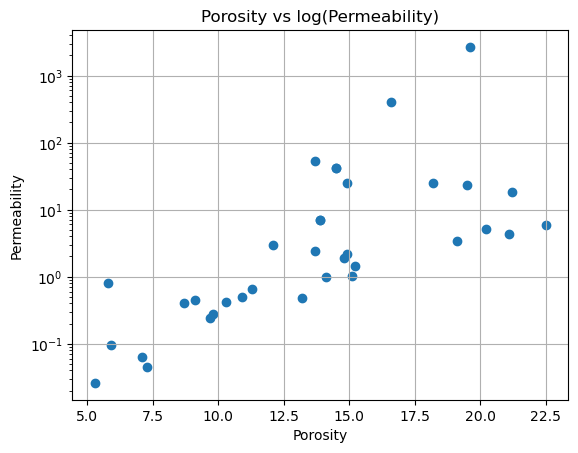

In [8]:
plt.scatter(porosity, permeability)
plt.xlabel('Porosity')
plt.ylabel('Permeability')
plt.title('Porosity vs log(Permeability)')
plt.yscale('log')
plt.grid()

plt.show()


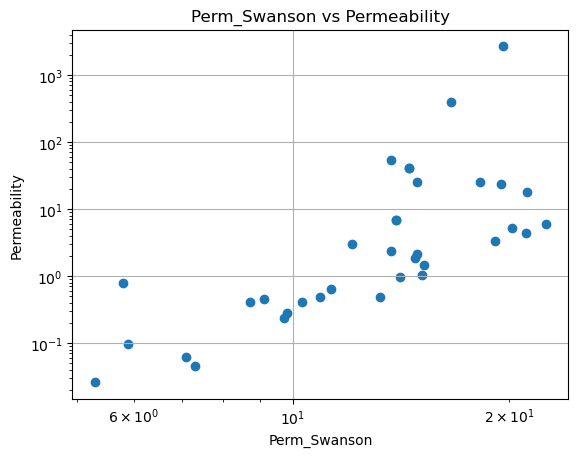

In [9]:
plt.scatter(porosity, permeability)
plt.xlabel('Perm_Swanson')
plt.ylabel('Permeability')
plt.title('Perm_Swanson vs Permeability')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.show()


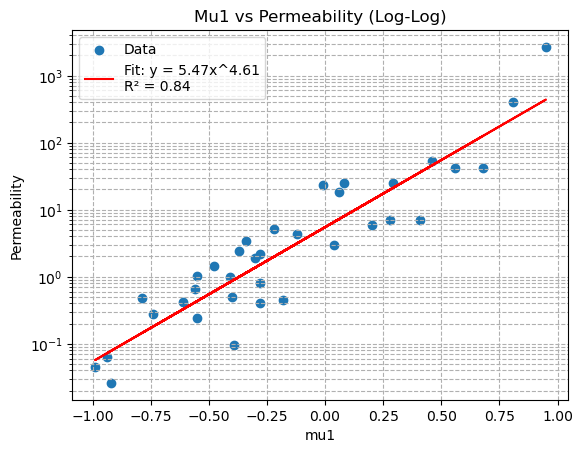

In [10]:
# Log-transform the data for linear regression
log_mu1 = mu1
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(mu1, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(mu1, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('mu1')
plt.ylabel('Permeability')
plt.title('Mu1 vs Permeability (Log-Log)')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


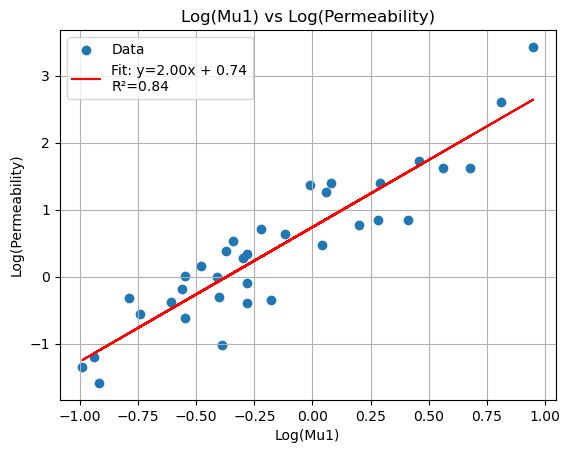

In [11]:
# Assuming lmu1 and lperm are the log-transformed data arrays for mu1 and permeability

# Perform linear regression using numpy.polyfit
slope, intercept = np.polyfit(mu1, lperm, 1)

# Calculate the predicted values for lperm
lperm_pred = slope * mu1 + intercept

# Calculate R² correctly
ss_res = np.sum((lperm - lperm_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((lperm - np.mean(lperm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot and the regression line
plt.scatter(mu1, lperm, label='Data')

# Plot the regression line (on the log-log scale)
plt.plot(mu1, lperm_pred, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}\nR²={r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Log(Mu1)')
plt.ylabel('Log(Permeability)')
plt.title('Log(Mu1) vs Log(Permeability)')

plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


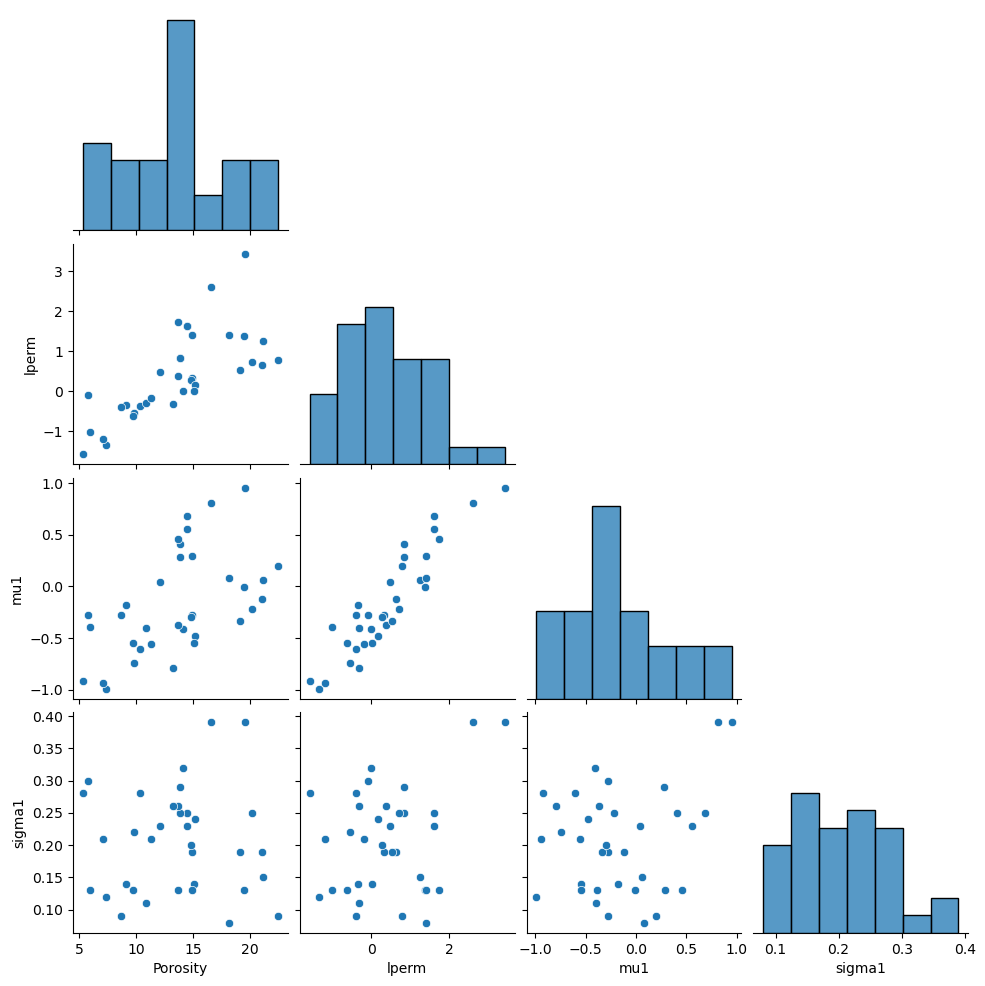

In [12]:
import seaborn as sns


# Create a new DataFrame with the columns of interest
data_to_plot = df[['Porosity', 'lperm',  'mu1', 'sigma1']]

# Create a pairplot of all the selected data
sns.pairplot(data_to_plot, corner=True)

# Show the plot
